# Skin Cancer Identifier 
# Author: Owen Trudt

In [1]:
# imports
import os 
import pandas as pd 
import sklearn 
import tensorflow as tf 
import numpy as np 
import shutil
from sklearn.model_selection import train_test_split 
import tensorflow as tf
import keras 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import layers
from tensorflow.keras import Model 
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from PIL import Image

270


C:\Users\ot7sl\AppData\Local\Temp\ipykernel_11740\1265660134.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_path = data[0]


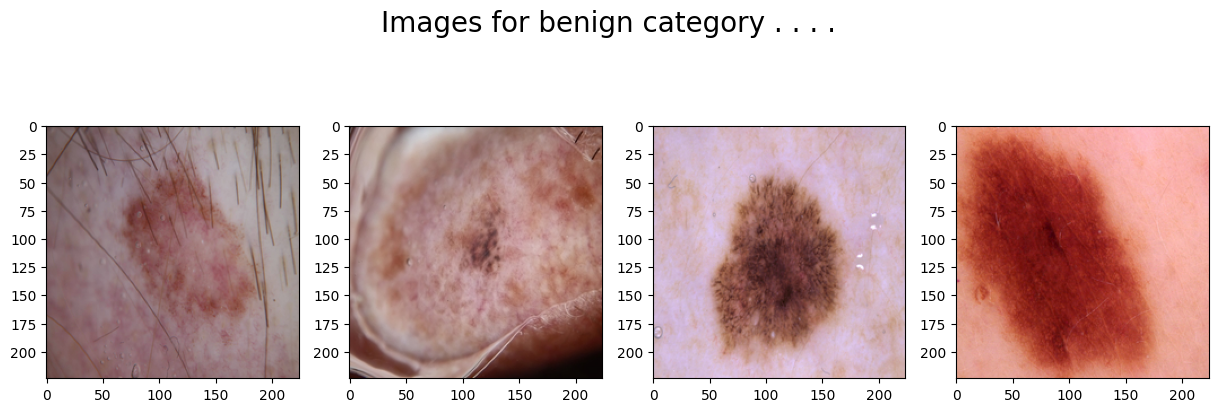

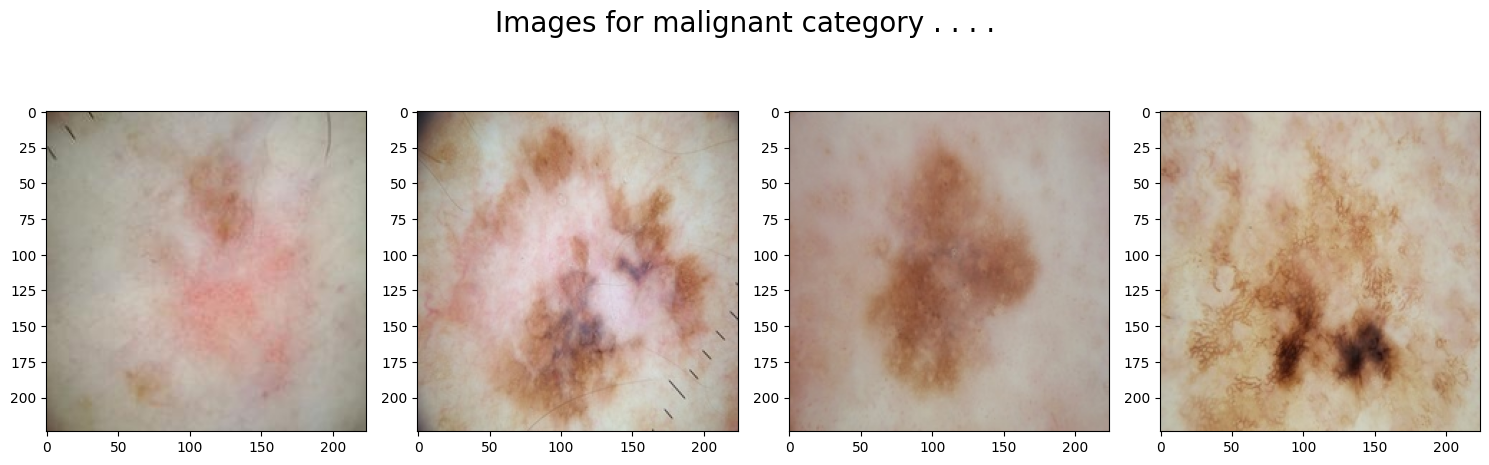

In [108]:
# data investigation and augmentation
import glob
import random
DATA_PATH = "C:/Users/ot7sl/Favorites/repo_house/PersonalProjects/DataSets/skin-cancer-data/train_cancer/*/*.jpg"

data = glob.glob(DATA_PATH)
print(len(data))

images = [path.replace('\\', '/') for path in data]

df = pd.DataFrame({'filepath': images})

df['label'] = df['filepath'].apply(lambda x: x.split('/')[-2])

df.head()

for cat in df['label'].unique():
    temp = df[df['label'] == cat]
 
    index_list = temp.index
    fig, ax = plt.subplots(1, 4, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)
    for i in range(4):
        index = np.random.randint(0, len(index_list))
        index = index_list[index]
        data = df.iloc[index]
 
        image_path = data[0]
 
        img = np.array(Image.open(image_path))
        ax[i].imshow(img)
plt.tight_layout()
plt.show()



In [109]:
# make labels 1 and 0 
df.head()
df['binary_label'] = np.where(df['label'].values=='benign', 0, 1)
df.head()

,filepath,label,binary_label
0,C:/Users/ot7sl/Favorites/repo_house/PersonalPr...,benign,0
1,C:/Users/ot7sl/Favorites/repo_house/PersonalPr...,benign,0
2,C:/Users/ot7sl/Favorites/repo_house/PersonalPr...,benign,0
3,C:/Users/ot7sl/Favorites/repo_house/PersonalPr...,benign,0
4,C:/Users/ot7sl/Favorites/repo_house/PersonalPr...,benign,0


In [110]:
# seperate into features and target 

features = df['filepath']
target = df['binary_label']

train_x, test_X, train_y, test_Y = train_test_split(features, target, test_size=0.1, random_state=28)


In [111]:
label_map = {'benign': 0, 'malignant': 1}
df['label'] = df['label'].map(label_map)
df.head()

,filepath,label,binary_label
0,C:/Users/ot7sl/Favorites/repo_house/PersonalPr...,0,0
1,C:/Users/ot7sl/Favorites/repo_house/PersonalPr...,0,0
2,C:/Users/ot7sl/Favorites/repo_house/PersonalPr...,0,0
3,C:/Users/ot7sl/Favorites/repo_house/PersonalPr...,0,0
4,C:/Users/ot7sl/Favorites/repo_house/PersonalPr...,0,0


In [112]:
def decode_image(filepath, label):
    # Read and decode the image
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # Resize to the desired size
    
    # Normalize the image to [0, 1] range
    image = image / 255.0
    
    return image, label

In [2]:
from sympy import false
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2L
from tensorflow.keras.applications.vgg19 import VGG19

model = VGG19(
    include_top=false, 
    input_shape=(224, 224, 3),
    weights='imagenet' 
)

In [114]:
for layer in model.layers: 
    layer.trainable = false 

In [115]:


inputs = keras.Input(shape=(224, 224, 3))
data_aug_layer = keras.Sequential(
    [keras.layers.RandomFlip(mode="horizontal"),
     keras.layers.RandomRotation(fill_mode="reflect", factor=0.1),
     keras.layers.RandomZoom(-0.1),
     ]
)
x = data_aug_layer(inputs)
x = keras.applications.vgg19.preprocess_input(x)
x = model(x, training=false)
x = keras.layers.Conv2D(8, (3,3), activation='relu')(x)
x = keras.layers.Dense(16, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1)(x)
fin_model = keras.Model(inputs, outputs)


In [116]:
fin_model.compile(optimizer='adam', 
                  loss=keras.losses.BinaryCrossentropy(from_logits=True), 
                  metrics=[keras.metrics.BinaryAccuracy(), 
                           keras.metrics.FalseNegatives(),
                           ],
                           )

In [117]:
train_set = (
    tf.data.Dataset
    .from_tensor_slices((train_x, train_y))
    .map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

test_set = (
    tf.data.Dataset
    .from_tensor_slices((test_X, test_Y))
    .map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

In [118]:
history = fin_model.fit(train_set, epochs=5, validation_data=test_set)

Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - binary_accuracy: 0.8878 - false_negatives_6: 2.0000 - loss: 0.4028 - val_binary_accuracy: 0.9630 - val_false_negatives_6: 0.0000e+00 - val_loss: 0.1726
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - binary_accuracy: 0.9077 - false_negatives_6: 0.0000e+00 - loss: 0.3125 - val_binary_accuracy: 0.9630 - val_false_negatives_6: 0.0000e+00 - val_loss: 0.2015
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - binary_accuracy: 0.9077 - false_negatives_6: 0.0000e+00 - loss: 0.3271 - val_binary_accuracy: 0.9630 - val_false_negatives_6: 0.0000e+00 - val_loss: 0.2187
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - binary_accuracy: 0.9077 - false_negatives_6: 0.0000e+00 - loss: 0.3217 - val_binary_accuracy: 0.9630 - val_false_negatives_6: 0.0000e+00 - val_loss: 0.2034
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - binary_accuracy: 0.9077 - false_negatives_6: 0.0000e+00 - loss: 0.3113 - val_binary_accuracy: 0.9630 - val_false_negatives_6: 0.0000e+0

In [94]:
hist_tracker = pd.DataFrame(history.history)
hist_tracker.head()

,binary_accuracy,false_negatives_3,loss,val_binary_accuracy,val_false_negatives_3,val_loss
0,0.769231,30.0,0.474529,0.916667,0.0,0.289751
1,0.876068,2.0,0.394680,0.916667,0.0,0.288655
2,0.880342,1.0,0.367316,0.916667,0.0,0.293079
3,0.880342,1.0,0.371402,0.916667,0.0,0.290622
4,0.884615,0.0,0.384716,0.916667,0.0,0.290484


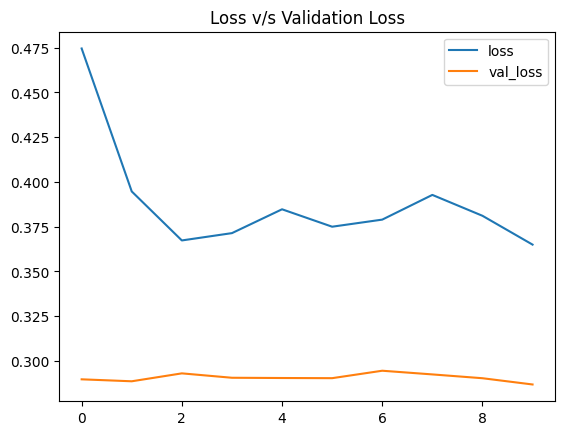

In [95]:
hist_tracker['loss'].plot()
hist_tracker['val_loss'].plot()
plt.title('Loss v/s Validation Loss')
plt.legend()
plt.show()

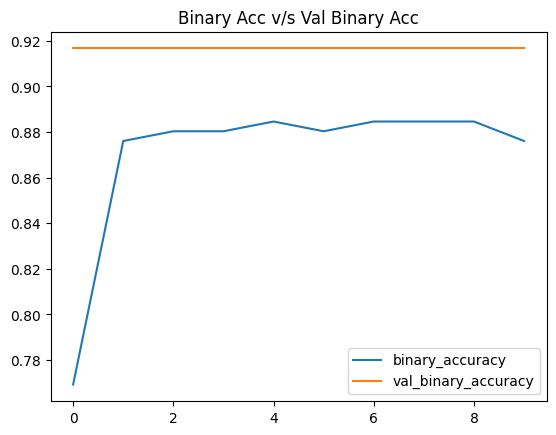

In [96]:
hist_tracker['binary_accuracy'].plot()
hist_tracker['val_binary_accuracy'].plot()
plt.title('Binary Acc v/s Val Binary Acc')
plt.legend()
plt.show()

First attempt above with a smaller dataset, I achieved good results my first test but could not replicate under different parameters, showing that this model is not stable. 
Will be using a larger dataset below

In [14]:
# Larger Data Set BEGIN

train_dir = "C:/Users/ot7sl/Favorites/repo_house/PersonalProjects/DataSets/skin-cancer-data/train_cancer_large/data/train/"
test_dir = "C:/Users/ot7sl/Favorites/repo_house/PersonalProjects/DataSets/skin-cancer-data/train_cancer_large/data/test/"

train_dg = ImageDataGenerator(
    rescale=1./255, 
    
)

test_dg = ImageDataGenerator(
    rescale=1./255
)

train_gen = train_dg.flow_from_directory(
    train_dir, 
    seed=100, 
    target_size=(224,224), 
    batch_size=20, 
    class_mode='binary'
)

test_gen = test_dg.flow_from_directory(
    test_dir, 
    seed=100, 
    target_size=(224,224), 
    batch_size=20, 
    class_mode='binary'
)



Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [21]:
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint

# we will still be using vgg19 

model = VGG19(
    include_top=False, 
    input_shape=(224, 224, 3),
    weights='imagenet' 
)

for layer in model.layers: 
    layer.trainable = False 


# inputs = keras.Input(shape=(224, 224, 3))
# data_aug_layer = keras.Sequential(
#     [keras.layers.RandomFlip(mode="horizontal"),
#      keras.layers.RandomRotation(fill_mode="reflect", factor=0.1),
#      keras.layers.RandomZoom(-0.1),
#      ]
# )
# x = data_aug_layer(inputs)
# x = keras.applications.vgg19.preprocess_input(x)
x = model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.7)(x)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.4)(x)
outputs = keras.layers.Dense(1, activation='relu')(x)

fin_modelv2 = keras.Model(inputs, outputs)

fin_modelv2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])




In [22]:
checkpoint = ModelCheckpoint('vgg19_best_model.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [23]:
historyv2 = fin_modelv2.fit(
        train_gen,
        epochs=10,
        validation_data=test_gen,
        verbose=2,
        callbacks=[checkpoint]
)

Epoch 1/10


KeyError: 'Exception encountered when calling Functional.call().\n\n\x1b[1m2523298038560\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=tf.Tensor(shape=(None, 224, 224, 3), dtype=float32)\n  • training=True\n  • mask=None'